###  Import

In [6]:
import os
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
%matplotlib inline

# keras_ocr
import keras_ocr

# 테서랙트
import pytesseract
from pytesseract import Output

### Step1. 검증용 데이터셋 준비

In [35]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/images/'
work_dir

'/home/aiffel-dj51/aiffel/ocr_python/images/'

In [36]:
images = glob(work_dir+'*.jpg')
images.sort()
images

['/home/aiffel-dj51/aiffel/ocr_python/images/01.jpg',
 '/home/aiffel-dj51/aiffel/ocr_python/images/02.jpg',
 '/home/aiffel-dj51/aiffel/ocr_python/images/03.jpg',
 '/home/aiffel-dj51/aiffel/ocr_python/images/04.jpg',
 '/home/aiffel-dj51/aiffel/ocr_python/images/05.jpg',
 '/home/aiffel-dj51/aiffel/ocr_python/images/06.jpg',
 '/home/aiffel-dj51/aiffel/ocr_python/images/07.jpg',
 '/home/aiffel-dj51/aiffel/ocr_python/images/08.jpg',
 '/home/aiffel-dj51/aiffel/ocr_python/images/09.jpg']

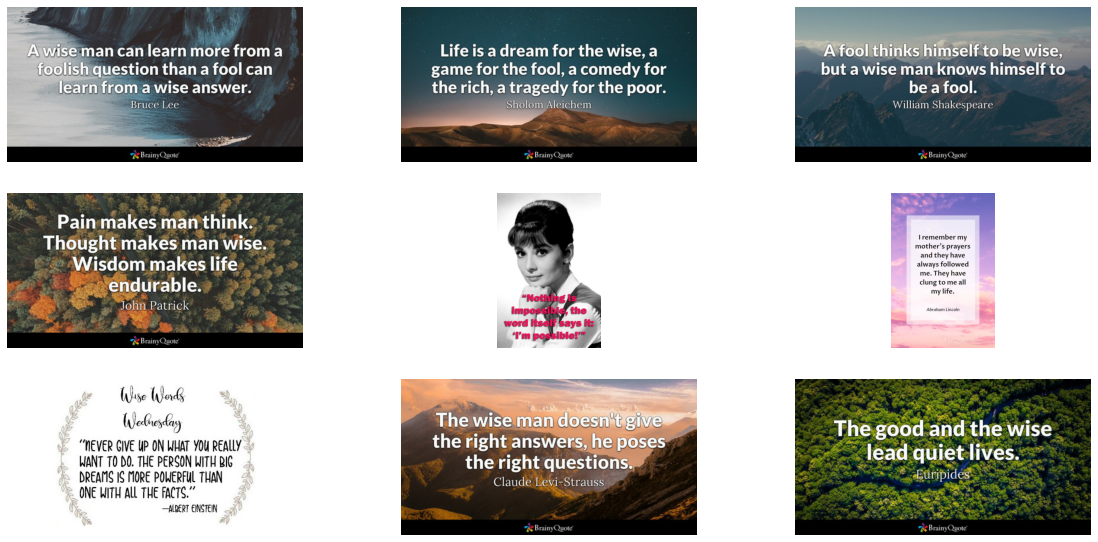

In [37]:
plt.figure(figsize=(20,20))

for idx, im in enumerate(images):
    plt.subplot(6, 3, idx+1)
    im = img.imread(im)
    plt.imshow(im)
    plt.axis('off')

### Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

#### Google OCR API

In [38]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [39]:
for im in images:
    detect_text(im)

DefaultCredentialsError: Could not automatically determine credentials. Please set GOOGLE_APPLICATION_CREDENTIALS or explicitly create credentials and re-run the application. For more information, please see https://cloud.google.com/docs/authentication/getting-started

#### keras-ocr

In [40]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel-dj51/.keras-ocr/craft_mlt_25k.h5
Looking for /home/aiffel-dj51/.keras-ocr/crnn_kurapan.h5


In [41]:
images_keras_ocr = [ keras_ocr.tools.read(im) for im in images]
prediction_groups = [pipeline.recognize([im]) for im in images]

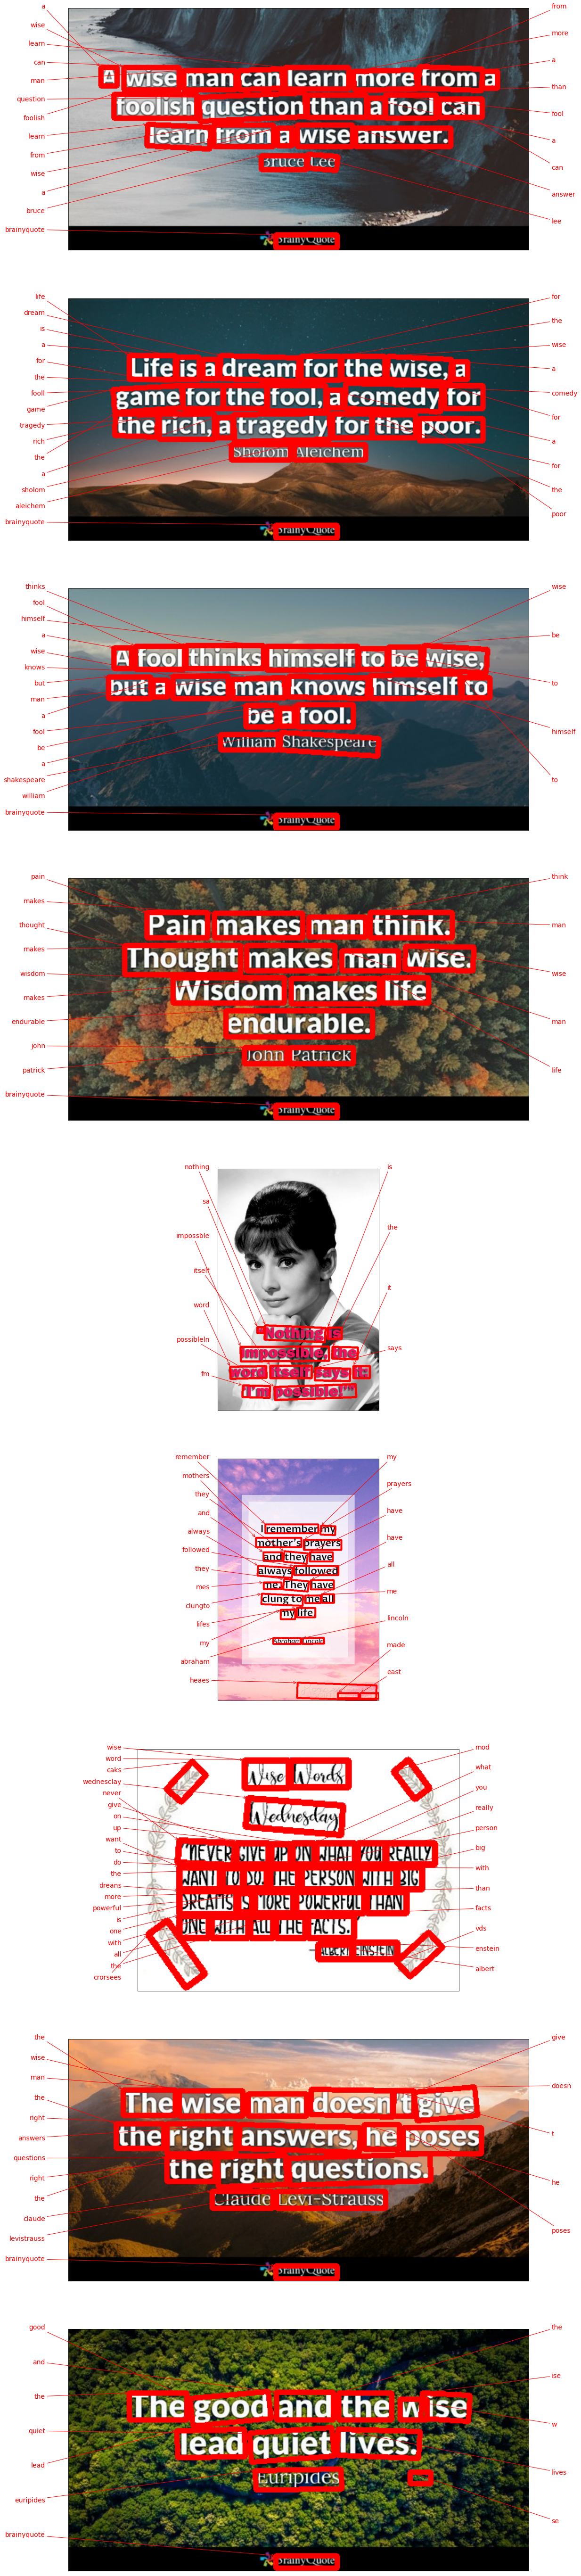

In [42]:
fig, axs = plt.subplots(nrows=len(images_keras_ocr), figsize=(100, 100))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images_keras_ocr[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

#### Tesseract

In [50]:
def crop_word_regions(idx, image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
        
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [51]:
print(work_dir)
cropped_image_path_list = []
for idx, img_path in enumerate(images):
    cropped_image_path_list.append(crop_word_regions(idx, img_path, f"{work_dir}tesseract/{idx}"))

/home/aiffel-dj51/aiffel/ocr_python/images/


FileNotFoundError: [Errno 2] No such file or directory: '/home/aiffel-dj51/aiffel/ocr_python/images/tesseract/0'

In [52]:
cropped_image_path_list

[]

In [53]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    result = ''
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        result += " ".join(recognized_data['text'].split()) + " "
    print(result)
    print("------------------------------Done------------------------------")
    print()

In [54]:
for cr_path in cropped_image_path_list:
    recognize_images(cr_path)

### 느낀점(회고)

9장의 이미지에 대해서 OCR을 진행해봤습니다.

성능을 확인해보면 다음과 같습니다.
Google OCR API > keras-ocr >>> Tesseract

Tesseract는 성능이 좋지 않았고, keras-ocr은 손글씨 형태의 글자에 대해서 인식률이 떨어지는 경향을 보였습니다. Google OCR API는 손글씨 형태의 글자도 잘 인식하는 것을 보였습니다.